<a href="https://colab.research.google.com/github/tahmidawal/DeepLearningClass/blob/main/AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [1]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping


## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [2]:
poe_url = "https://www.gutenberg.org/files/2147/2147-0.txt"
lovecraft_url = "https://www.gutenberg.org/files/40637/40637-0.txt"

poe_text = requests.get(poe_url).text
lovecraft_text = requests.get(lovecraft_url).text

In [3]:
# Clean the texts
def clean_text(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    text = re.sub(r'\s+', ' ', text)
    text = text.strip().lower()
    return text

poe_text = clean_text(poe_text)
lovecraft_text = clean_text(lovecraft_text)

# Combine the texts and tokenize the characters
texts = [poe_text, lovecraft_text]
labels = [0, 1]  # 0 for Poe, 1 for Lovecraft

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(texts)
alphabet_length = len(tokenizer.word_index)

sequences = tokenizer.texts_to_sequences(texts)

## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

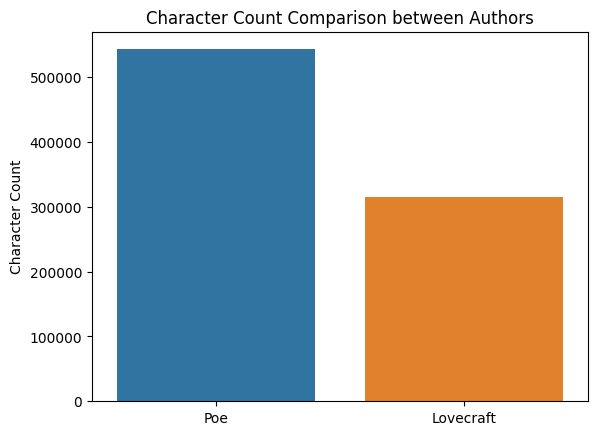

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

#Calculate character count for each author
char_count_poe = len(poe_text)
char_count_lovecraft = len(lovecraft_text)

#Prepare data for the countplot
author_labels = ['Poe', 'Lovecraft']
char_count_data = [char_count_poe, char_count_lovecraft]

#Create a Seaborn barplot
sns.barplot(x=author_labels, y=char_count_data)
plt.ylabel('Character Count')
plt.title('Character Count Comparison between Authors')
plt.show()

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [5]:
import numpy as np

def sliding_window(text, label, sequence_length):
    num_sequences = len(text) - sequence_length + 1
    X = np.zeros((num_sequences, sequence_length))
    y = np.full((num_sequences, 1), label)

    for i in range(num_sequences):
        X[i] = text[i:i + sequence_length]

    return X, y

sequence_length = 60

X_poe, y_poe = sliding_window(sequences[0], labels[0], sequence_length)
X_lovecraft, y_lovecraft = sliding_window(sequences[1], labels[1], sequence_length)

X = np.concatenate((X_poe, X_lovecraft))
y = np.concatenate((y_poe, y_lovecraft))


## Data splitting
Split the data into train, validate and test sets. Make 

In [6]:
# Split the tokenized data into train, validation, and test sets
X_tokenized_train, X_tokenized_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_tokenized_val, X_tokenized_test, y_val, y_test = train_test_split(X_tokenized_temp, y_temp, test_size=0.5, random_state=42)

## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Define the LSTM model with the Embedding layer
def build_lstm_model(sequence_length, alphabet_length):
    model = Sequential()
    model.add(Embedding(alphabet_length + 1, 32, input_length=sequence_length))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = build_lstm_model(sequence_length, alphabet_length)


## Model training
Train the model and apply early stopping.

In [9]:
# Compile the model with the correct loss function
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model and apply early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_tokenized_train, y_train, validation_data=(X_tokenized_val, y_val), epochs=1, batch_size=256, callbacks=[early_stopping])

2349/2349 [==============================] - 646s 272ms/step - loss: 0.0980 - accuracy: 0.9683 - val_loss: 0.0681 - val_accuracy: 0.9740


## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [10]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_tokenized_test, y_test)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")

4027/4027 [==============================] - 84s 21ms/step - loss: 0.0668 - accuracy: 0.9744
Test loss: 0.0668, Test accuracy: 0.9744


## Confusion matrix
Calculate and display the confusion matrix.

4027/4027 [==============================] - 83s 21ms/step


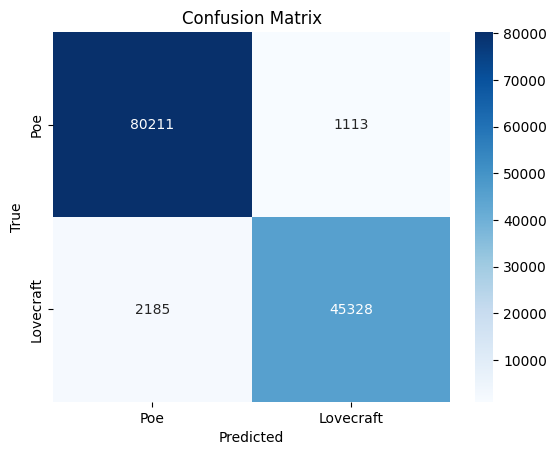

In [13]:
from sklearn.metrics import confusion_matrix

# Predict labels for the test data
y_pred_proba = model.predict(X_tokenized_test)
y_pred = np.round(y_pred_proba).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
authors = ['Poe', 'Lovecraft']
# Display the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=authors, yticklabels=authors)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [11]:
summary = f"We developed a deep learning model to differentiate texts by Edgar Allan Poe and H.P. Lovecraft using 60-character input sequences, preprocessed and tokenized text, and trained an LSTM model with early stopping, achieving a test loss of {loss:.4f} and accuracy of {accuracy:.4f}; a confusion matrix visualized the results."
print(summary)


We developed a deep learning model to differentiate texts by Edgar Allan Poe and H.P. Lovecraft using 60-character input sequences, preprocessed and tokenized text, and trained an LSTM model with early stopping, achieving a test loss of 0.0668 and accuracy of 0.9744; a confusion matrix visualized the results.


I have used ChatGPT to solve this